In [7]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import resnet_cifar10 as RN_cifar

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device = 'cuda'

import shutil
import time
 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
# import resnet as RN
# import pyramidnet as PYRM
# from allcnn import AllConvNet
 
import warnings
 
warnings.filterwarnings("ignore")

# import imagenet --------------------------------------------------------------------------------------------------

In [5]:
dataset = 'imagenet'
depth = 18
pretrained_vanilla = 'runs/imagenet_vanilla/model_best.pth.tar' #-------------------------------------change
pretrained_clewr = 'runs/clewr_exp/model_best.pth.tar'#------------------------------------------change
view_layer = 'module_layer4' #---------------------------------------------------------------------------or module_layer3
numberofclass = 1000

In [8]:
# Load vanilla model
# model1 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) #-----------------------check once
model1 = models.__dict__['resnet18']()
# model1 = RN_cifar.__dict__['resnet20']()
model1 = torch.nn.DataParallel(model1)
print("=> loading checkpoint '{}'".format(pretrained_vanilla))
checkpoint = torch.load(pretrained_vanilla, map_location=torch.device('cpu'))
model1.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_vanilla))

# print(model)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model1.parameters()])))
model1.to(device).eval()


=> loading checkpoint 'imagenet_vanilla/model_best.pth.tar'
=> loaded checkpoint 'imagenet_vanilla/model_best.pth.tar'
the number of model parameters: 11689512


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
# Load clewr model
# model2 = RN.ResNet(dataset=dataset, depth=depth, num_classes=numberofclass, bottleneck=True) 
model2 = models.__dict__['resnet18']()
model2 = torch.nn.DataParallel(model2)

print("=> loading checkpoint '{}'".format(pretrained_clewr))
checkpoint = torch.load(pretrained_clewr, map_location=torch.device('cpu') )
model2.load_state_dict(checkpoint['state_dict'], strict=False)
print("=> loaded checkpoint '{}'".format(pretrained_clewr))

print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model2.parameters()])))
model2.to(device).eval()

=> loading checkpoint 'imagenet_clewr/model_best.pth.tar'
=> loaded checkpoint 'imagenet_clewr/model_best.pth.tar'
the number of model parameters: 11689512


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [10]:
configs1 = [dict(model_type='densenet', arch=model1, layer_name=view_layer)]
configs2 = [dict(model_type='densenet', arch=model2, layer_name=view_layer)]

# gradcam = GradCAM.from_config(model_type='resnet', arch=model, layer_name='layer3')
cams1 = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs1
]
cams2 = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs2
]

In [14]:
if dataset == 'imagenet':
    data_dir = '/home/ankita/scratch/Imagenet/ILSVRC/Data/CLS-LOC' #-----------------------------------------------------change
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std) #--------------------------------change
            ])
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transforms) 

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
    numberofclass = 1000
    # mean = [0.4802, 0.4481, 0.3975] #---------------------------------------------------------------------------------chnage
    # std = [0.2302, 0.2265, 0.2262]  #---------------------------------------------------------------------------------chnage
    
it = iter(val_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


977 978 977


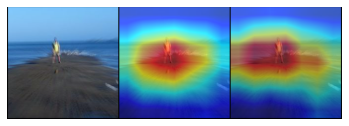

In [51]:

for i in range(1):
    images = []
    torch_img, target = it.next()
    img_np = torch_img.numpy()[0]
    img_np = np.swapaxes(img_np, 0, 2)
    img_np = np.swapaxes(img_np, 0, 1)
    a = (img_np - img_np.min())
    a = a/a.max()
    a = np.swapaxes(a, 0, 2)
    a = np.swapaxes(a, 1, 2)
    original_image = torch.tensor(a)
    img_arr = [original_image.cpu()]

    target = target.numpy()[0]

    logits = []
    for gradcam, gradcam_pp in cams1:
        mask, logit = gradcam(torch_img, target)
        heatmap, result = visualize_cam(mask, torch_img)

        mask_pp, _ = gradcam_pp(torch_img, target)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        
        result_f = (3*heatmap_pp/5 + original_image/2 )
        
        img_arr.extend([result_f])
        
        logit = np.argmax(logit.detach().cpu().numpy(), -1)[0]
        logits.extend([logit])
        result_f1 = result_f
        
    for gradcam, gradcam_pp in cams2:
        mask, logit = gradcam(torch_img, target)
        heatmap, result = visualize_cam(mask, torch_img)

        mask_pp, _ = gradcam_pp(torch_img, target)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        
        result_f = (heatmap_pp/2 + original_image/2 )
        
        img_arr.extend([result_f])
        
        logit = np.argmax(logit.detach().cpu().numpy(), -1)[0]
        logits.extend([logit])
        result_f2 = result_f
        
    images.extend(img_arr)
    print(target, logits[0], logits[1])
    grid_image = make_grid(images, nrow=3)
    grid_img = grid_image.numpy()
    grid_img = np.swapaxes(grid_img, 0, 2)
    grid_img = np.swapaxes(grid_img, 0, 1)
    plt.imshow(grid_img)
    plt.axis('off')
    if(logits[1] == target):
        if(target == logits[0]): #----------------------------------------change the saving folder below
            plt.savefig('cams/' + "allsame" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
        else:
            plt.savefig('cams/' + "clewr" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


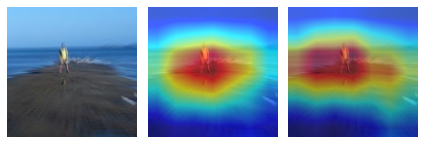

In [58]:
# plt.xticks([]),plt.yticks([])
fig, axes = plt.subplots(1, 3)
fig.tight_layout()

im1 = original_image.cpu()
im1 = np.swapaxes(im1, 0, 2)
im1 = np.swapaxes(im1, 0, 1)
plt.subplot(131), plt.imshow(im1)
plt.axis('off')

im2 = result_f1.cpu()
im2 = np.swapaxes(im2, 0, 2)
im2 = np.swapaxes(im2, 0, 1)
plt.subplot(132), plt.imshow(im2)
plt.axis('off')

im3 = result_f2.cpu()
im3 = np.swapaxes(im3, 0, 2)
im3 = np.swapaxes(im3, 0, 1)
plt.subplot(133), plt.imshow(im3)
plt.axis('off')

plt.tight_layout()

In [26]:
corrupted_data_dir = '/home/ankita/scratch/Imagenet-C' #------------------------------------chnage
distortion_string = ["brightness" , 'contrast' , 'defocus_blur' , 'elastic_transform'  , 'fog' , 'frost' , 'gaussian_noise', 'impulse_noise' , 'jpeg_compression','motion_blur','pixelate', 'shot_noise' , 'snow', 'zoom_blur']


In [20]:
for x  in distortion_string:
    os.makedirs('cams-Corrupted/' + x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


brightness


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

contrast


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

defocus_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

elastic_transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

fog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

frost


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

gaussian_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

impulse_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

jpeg_compression


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

motion_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

pixelate


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

shot_noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

snow


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

zoom_blur


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

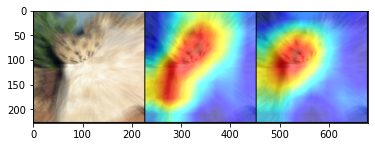

In [28]:
for distortion_name in  distortion_string : 
    severity = 3
#     -------------------------------------------change the info below similar to the data loarder above
    data_dir = '/home/ankita/scratch/Imagenet-C/' + distortion_name + '/' + str(severity) + '/'
    val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            ])
    val_dataset = datasets.ImageFolder(os.path.join(data_dir), val_transforms) 

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
    numberofclass = 1000
    it = iter(val_loader)
    print(distortion_name)
    
    for i in range(50):
        images = []
        torch_img, target = it.next()
        img_np = torch_img.numpy()[0]
        img_np = np.swapaxes(img_np, 0, 2)
        img_np = np.swapaxes(img_np, 0, 1)
        a = (img_np - img_np.min())
        a = a/a.max()
        a = np.swapaxes(a, 0, 2)
        a = np.swapaxes(a, 1, 2)
        original_image = torch.tensor(a)
        img_arr = [original_image.cpu()]

        target = target.numpy()[0]

        logits = []
        for gradcam, gradcam_pp in cams1:
            mask, logit = gradcam(torch_img, target)
            heatmap, result = visualize_cam(mask, torch_img)

            mask_pp, _ = gradcam_pp(torch_img, target)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

            result_f = (2*heatmap_pp/3 + original_image/2 )

            img_arr.extend([result_f])

            logit = np.argmax(logit.detach().cpu().numpy(), -1)[0]
            logits.extend([logit])
        for gradcam, gradcam_pp in cams2:
            mask, logit = gradcam(torch_img, target)
            heatmap, result = visualize_cam(mask, torch_img)

            mask_pp, _ = gradcam_pp(torch_img, target)
            heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

            result_f = (2*heatmap_pp/3 + original_image/2 )

            img_arr.extend([result_f])

            logit = np.argmax(logit.detach().cpu().numpy(), -1)[0]
            logits.extend([logit])

        images.extend(img_arr)
#         print(target, logits[0], logits[1])
        grid_image = make_grid(images, nrow=3)
        grid_img = grid_image.numpy()
        grid_img = np.swapaxes(grid_img, 0, 2)
        grid_img = np.swapaxes(grid_img, 0, 1)
        plt.imshow(grid_img)
        if(logits[1] == target):
            if(target == logits[0]):
                plt.savefig('cams-Corrupted/' + distortion_name + "/allsame" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
            else:
                plt.savefig('cams-Corrupted/' + distortion_name + "/clewr" + str(target) + "-" + str(logits[0]) + "-" + str(logits[1]) + "  " +str(i))
